# This notebook shows implementation of a neural network to classify cat vs. dog images

This example comes from this Keras tutorial: https://keras.io/examples/vision/image_classification_from_scratch/

The data in this example comes from Kaggle and has been previously downloaded to my local drive:  
https://www.kaggle.com/chetankv/dogs-cats-images

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import pydot
from skimage import io
import numpy as np

In [5]:
np.random.seed(42)

## Check if the images are corrupted and remove those that are

In [6]:
num_skipped = 0
for folder_name in ("cat", "dog"):
    folder_path = os.path.join("./cat_dog_images/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate training and test datasets

In [7]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./cat_dog_images/",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./cat_dog_images/",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


## Visualize and explore the data

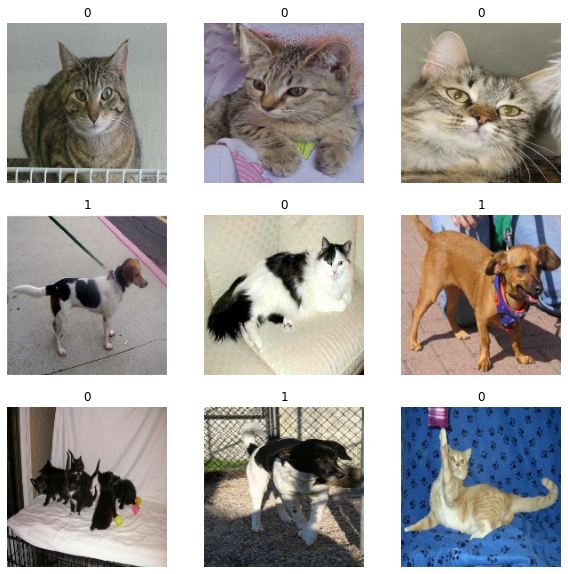

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Augment the data

Data augmentation is a strategy employeed in image processing when an image is modified in some small ways to create new images (e.g. rotated a bit, randomly transformed, etc.)

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

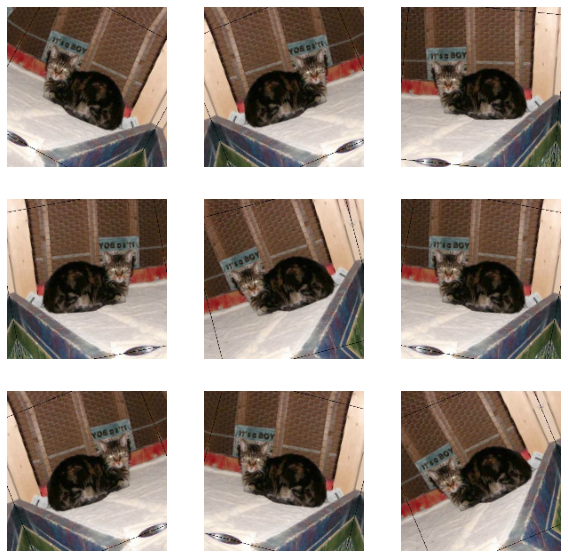

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Define model architecture

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
_______________________________________________________________________________________

## Train the model

In [8]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
250/250 [==============================] - 757s 3s/step - loss: 0.6833 - accuracy: 0.6199 - val_loss: 0.7675 - val_accuracy: 0.4900
Epoch 2/50
250/250 [==============================] - 744s 3s/step - loss: 0.5653 - accuracy: 0.7154 - val_loss: 1.0964 - val_accuracy: 0.4905
Epoch 3/50
250/250 [==============================] - 746s 3s/step - loss: 0.4976 - accuracy: 0.7614 - val_loss: 0.4852 - val_accuracy: 0.7760
Epoch 4/50
250/250 [==============================] - 759s 3s/step - loss: 0.4500 - accuracy: 0.7929 - val_loss: 0.5549 - val_accuracy: 0.7265
Epoch 5/50
250/250 [==============================] - 758s 3s/step - loss: 0.4043 - accuracy: 0.8164 - val_loss: 0.3715 - val_accuracy: 0.8260
Epoch 6/50
250/250 [==============================] - 762s 3s/step - loss: 0.3726 - accuracy: 0.8346 - val_loss: 0.4309 - val_accuracy: 0.8095
Epoch 7/50
250/250 [==============================] - 793s 3s/step - loss: 0.3436 - accuracy: 0.8482 - val_loss: 1.3587 - val_accuracy: 0.5465

## Classify an unseen image

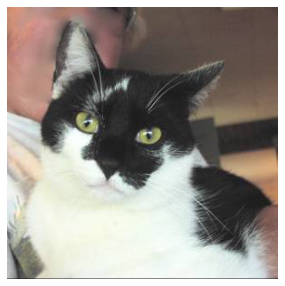

In [18]:
img = io.imread('./cat_dog_images/cat/cat.999.jpg')
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.imshow(img)

In [14]:
img = keras.preprocessing.image.load_img(
    "./cat_dog_images/cat/cat.999.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent cat and 0.00 percent dog.


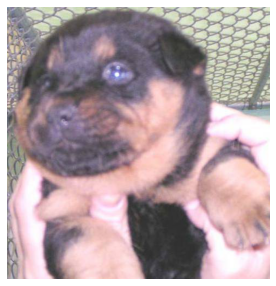

In [19]:
img = io.imread('./cat_dog_images/dog/dog.999.jpg')
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.imshow(img)

In [15]:
img = keras.preprocessing.image.load_img(
    "./cat_dog_images/dog/dog.999.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 6.43 percent cat and 93.57 percent dog.


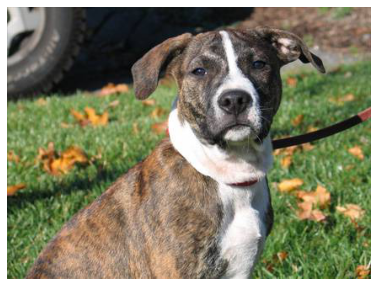

In [20]:
img = io.imread('./cat_dog_images/dog/dog.799.jpg')
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.imshow(img)

In [21]:
img = keras.preprocessing.image.load_img(
    "./cat_dog_images/dog/dog.799.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent cat and 100.00 percent dog.
